In [1]:
import pickle
import pandas as pd
import numpy as np
import sys
import time

In [2]:
def bitlist_sim_pairwise(A, tnodes, w, sim):
    undo = range(tnodes[0], tnodes[1]+1)
    undo_array = np.zeros(tnodes[1]+1)
    for i in undo: undo_array[i] = 1
    bit_list = []
    now = 0
    ret = {}
    i = 1
    pre = 0
    while len(undo) > 0:
        #print len(undo), len(undo_array.nonzero()[0]), pre
        best = 0
        if now == w:
            now = 0
        if now == 0:
            best = undo.pop()
            bit_list = A[best]
            pre = best
        else:
            best = (undo_array * sim[pre]).argmax()
            #print sim[pre][best]
            if best == 0:
                best = undo.pop()
            else:
                undo.remove(best)
            pre = best

        undo_array[best] = 0
              
        ret[best] = i
        i += 1
        now += 1
        
    return ret


In [3]:
def bitlist_sim_pairwise_middle(A, tnodes, w, sim):
    undo = range(tnodes[0], tnodes[1]+1)
    undo_array = np.zeros(tnodes[1]+1)
    for i in undo: undo_array[i] = 1
    bit_list = np.zeros(w+1)
    now = 0
    ret = {}
    i = 1
    pre = 0
    while len(undo) > 0:
        #print len(undo), len(undo_array.nonzero()[0]), pre
        best = 0
        if now == w:
            now = 0
        if now == 0:
            best = undo.pop()
            pre = best
        else:
            best = (undo_array * sim[bit_list[int(now/2)]]).argmax()
            #print sim[pre][best]
            if best == 0:
                best = undo.pop()
            else:
                undo.remove(best)
            pre = best
        bit_list[now] = best
        undo_array[best] = 0
              
        ret[best] = i
        i += 1
        now += 1
        
    return ret

In [4]:
def transform(A, t, n_nodes):
    Ak = np.zeros((n_nodes+2,n_nodes+2))
    x,y = A.nonzero()
    for i in xrange(len(x)):
        _x = (x[i] in t) and t[x[i]] or x[i]
        _y = (y[i] in t) and t[y[i]] or y[i]
        Ak[_x][_y] = Ak[_y][_x] = 1
    return Ak

In [5]:
def get_data(folder_name, n_rows, max_nodes):
    file_name = "./data/A_%s_%d_%d.txt" % \
        (folder_name, n_rows, max_nodes)
    s = open(file_name, 'r').read()
    ls = s.split('\n')
    n_nodes = int(ls[-2].split('\t')[0])+2
    n_edge = len(ls)-4
    n_tnodes = int(ls[0].split(' ')[-1])
        
        
    A = np.zeros( (n_nodes+2,n_nodes+2) )
    for l in s.split('\n'):
        t = l.split('\t')
        if len(t) == 2:
            t1 = int(t[0])
            t2 = int(t[1])
            A[t1][t2] = A[t2][t1] = 1

    return A, n_nodes, n_edge, n_tnodes

In [6]:
def filled_bits(_interval, transform, M, n_tnodes, n_nodes, t = None):
    n = 0
    total = 0
    for i in xrange(n_tnodes+1,n_nodes):
        for j in xrange(1,n_tnodes,_interval):
            total += 1
            for k in xrange(_interval):
                if j+k > n_nodes: break
                if transform:
                    if M[t[i]][j+k] == 1:
                        #print j+k,
                        n += 1
                        break                    
                else:
                    if M[i][j+k] == 1:
                        #print j+k,
                        n += 1
                        break
    return (n, total)

In [7]:
from itertools import combinations
def lsh(min_hash, b, r, A, n_tnodes):
    sim = np.zeros((n_tnodes+1, n_tnodes+1))
    for i in range(b):
        buk = {}
        for tid in min_hash.keys():
            k = str(min_hash[tid][i*r:(i+1)*r])
            if str(k) not in buk.keys():
                buk[k] = []
            buk[k].append(tid)
        print 'buk builded'
        sys.stdout.flush()
        for key in buk.keys():
            for i,j in combinations(buk[key], 2):
                #print i,j
                if sim[i][j] != 0: continue
                sim[i][j] = sum(np.logical_and(A[i], A[j])) \
                    * 1.0 / sum(np.logical_or(A[i],A[j]))
                sim[j][i] = sim[i][j]
                #print sim[i][j]
    return sim

In [9]:
g_folder = '02'
g_n_rows = 2000
g_max_nodes = 50
A, n_nodes, n_edge, n_tnodes = \
	get_data(g_folder, g_n_rows, g_max_nodes)

In [10]:
f = open(('./data/MINH_%s_%d_%d.pickle'%(g_folder,g_n_rows, g_max_nodes)),'r')
min_hash = pickle.load(f)
print min_hash['time']
del min_hash['time']

2404.73240018


In [11]:
f = open(('./data/SJ_%s_%d_%d.pickle'%(g_folder,g_n_rows, g_max_nodes)),'r')
sim = pickle.load(f)

In [93]:
t1 = time.time()
sim = lsh(min_hash, 1,5,A,n_tnodes)
t2 = time.time()
print t2-t1

buk builded
20.9271290302


In [94]:
t = bitlist_sim_pairwise(A, (1, n_tnodes), 4, sim)
Ak = transform(A, t, n_nodes)
r = filled_bits(4, False, Ak, n_tnodes, n_nodes)
print r

(47227, 901888)


In [98]:
t1 = time.time()
sim = lsh(min_hash, 1,5,A,n_tnodes)
t2 = time.time()
print t2-t1

buk builded
21.5048429966


In [99]:
t = bitlist_sim_pairwise(A, (1, n_tnodes), 4, sim)
Ak = transform(A, t, n_nodes)
r = filled_bits(32, False, Ak, n_tnodes, n_nodes)
print r

(34875, 112736)


In [16]:
# new similarity compare
t = bitlist_sim_pairwise_middle(A, (1, n_tnodes), 4, sim)
Ak = transform(A, t, n_nodes)
r = filled_bits(4, False, Ak, n_tnodes, n_nodes)
print r

(40039, 901888)


In [19]:
# new similarity compare
t = bitlist_sim_pairwise_middle(A, (1, n_tnodes), 16, sim)
Ak = transform(A, t, n_nodes)
r = filled_bits(16, False, Ak, n_tnodes, n_nodes)
print r

(30625, 225472)


In [18]:
# new similarity compare
t = bitlist_sim_pairwise_middle(A, (1, n_tnodes), 64, sim)
Ak = transform(A, t, n_nodes)
r = filled_bits(64, False, Ak, n_tnodes, n_nodes)
print r

(18708, 56368)


In [12]:
import json
folders = ['01','01','01','01','02','02']
n_rows = [1000, 5000, 10000, 15000, 2000, 3000]
max_nodes = [100, 50, 50, 50, 50, 100]
result = []
for i in range(len(folders)):
    f = open(('./result/BL_%s_%d_%d.txt'%(folders[i],n_rows[i], max_nodes[i])),'r')
    s = f.read()
    f.close()
    rsts = json.loads(s)
    A, n_nodes, n_edge, n_tnodes = \
        get_data(folders[i],n_rows[i], max_nodes[i])
    f = open('./data/SJ_%s_%d_%d.pickle'%(folders[i],n_rows[i], max_nodes[i]),'r')
    sim = pickle.load(f)
    f.close()
    for rst in rsts:
        t = bitlist_sim_pairwise_middle(A, (1, n_tnodes), rst['width'], sim)
        Ak = transform(A, t, n_nodes)
        r = filled_bits(rst['width'], False, Ak, n_tnodes, n_nodes)
        rst['bitlist#_middle_sim_jaccard'] = r[0]
        result.append(rst)

In [35]:
df = pd.DataFrame(result)

In [43]:
df[['n_trajectory','n_cell','width','bitlist#_seq','bitlist#_origin','bitlist#_first_sim_jaccard',\
   'bitlist#_2wise_sim_jaccard','bitlist#_first_sim_hamming','bitlist#_2wise_sim_hamming']]

,n_trajectory,n_cell,width,bitlist#_seq,bitlist#_origin,bitlist#_first_sim_jaccard,bitlist#_2wise_sim_jaccard,bitlist#_first_sim_hamming,bitlist#_2wise_sim_hamming
0,169,18,4,103,76,75,70,74,74
1,169,18,16,48,32,37,32,34,39
2,169,18,64,23,17,18,21,18,20
3,273,48,4,394,328,290,283,299,287
4,273,48,16,237,149,179,168,194,197
5,273,48,64,143,76,137,99,137,132
6,491,92,4,952,751,712,682,725,695
7,491,92,16,622,367,510,387,446,489
8,491,92,64,344,188,352,257,281,279
9,675,124,4,1541,1154,1161,1066,1164,1114


In [47]:
df2 = pd.DataFrame(result)

In [50]:
df2[['n_trajectory','n_cell','width','bitlist#_seq','bitlist#_origin','bitlist#_2wise_sim_jaccard',\
   'bitlist#_first_sim_jaccard','bitlist#_middle_sim_jaccard','bitlist#_2wise_sim_hamming','bitlist#_first_sim_hamming']]

,n_trajectory,n_cell,width,bitlist#_seq,bitlist#_origin,bitlist#_2wise_sim_jaccard,bitlist#_first_sim_jaccard,bitlist#_middle_sim_jaccard,bitlist#_2wise_sim_hamming,bitlist#_first_sim_hamming
0,169,18,4,103,76,70,75,69,74,74
1,169,18,16,48,32,32,37,34,39,34
2,169,18,64,23,17,21,18,20,20,18
3,273,48,4,394,328,283,290,286,287,299
4,273,48,16,237,149,168,179,189,197,194
5,273,48,64,143,76,99,137,96,132,137
6,491,92,4,952,751,682,712,702,695,725
7,491,92,16,622,367,387,510,469,489,446
8,491,92,64,344,188,257,352,267,279,281
9,675,124,4,1541,1154,1066,1161,1081,1114,1164


In [11]:
[]*4

[]

In [13]:
df = pd.DataFrame(result)

In [14]:
df[['n_trajectory','n_cell','width','bitlist#_seq','bitlist#_origin','bitlist#_first_sim_jaccard',\
   'bitlist#_2wise_sim_jaccard','bitlist#_first_sim_hamming','bitlist#_2wise_sim_hamming']]

,n_trajectory,n_cell,width,bitlist#_seq,bitlist#_origin,bitlist#_first_sim_jaccard,bitlist#_2wise_sim_jaccard,bitlist#_first_sim_hamming,bitlist#_2wise_sim_hamming
0,169,18,4,103,76,75,70,74,74
1,169,18,16,48,32,37,32,34,39
2,169,18,64,23,17,18,21,18,20
3,273,48,4,394,328,290,283,299,287
4,273,48,16,237,149,179,168,194,197
5,273,48,64,143,76,137,99,137,132
6,491,92,4,952,751,712,682,725,695
7,491,92,16,622,367,510,387,446,489
8,491,92,64,344,188,352,257,281,279
9,675,124,4,1541,1154,1161,1066,1164,1114


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

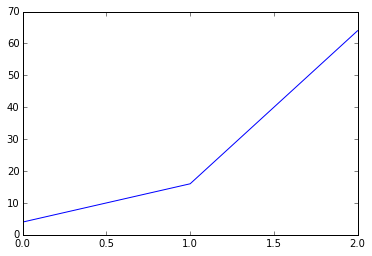

In [17]:
plt.plot([4,16, 64])

In [ ]:
bitlist_sim_pairwise_middle(A, (1, n_tnodes), rst['width'], sim)

In [72]:
reload(bitlist)

<module 'bitlist' from 'bitlist.py'>

In [79]:
t_num, max_nodes = 1000, 100
A = np.fromfile('./data/A_short_%d_%d.data'%(t_num, max_nodes))

In [81]:
A = A.reshape((A.shape[0]/(t_num+1), (t_num+1)))

In [82]:
A.shape

(165, 1001)

In [39]:
import bitlist
import sys
import numpy as np
from scipy import sparse

In [180]:
def bitlist_origin(A, w):
    tnodes = A.shape[1]
    print 'Processing origin bitlist n_nodes:%d, base: %d' % (tnodes, w)
    undo = range(1,tnodes)
    undo_array = np.ones(A.shape[1])

    bit_list = []
    now = 0
    ans = []
    i = 0
    upper = 0
    weights = []
    mean_d = len(A.nonzero()[0])/A.shape[1]+1
    print 'mean_d:',mean_d
    while len(undo) > 0:
        #best = 0

        
        if now == w:
            now = 0
        if now == 0:
            #print undo
            best = undo[0]
            bit_list = A[:, best]
            upper = 0
            weights = np.zeros((1, A.shape[0]))
        else:
            weights[0] += A[:,best]
            sorted_weights = weights.argsort()[0][::-1]
            upper = np.sum(weights[0][sorted_weights][:mean_d])
            #print best, A[:,best]
            #print weights
            #print upper
            if A.shape[1]-len(undo) > 10: break
            
            bs = -1
            local_undo_array = undo_array.copy()
            for i in range(len(sorted_weights)):
                c = sorted_weights[i]
                to_visit = np.logical_and(A[c], local_undo_array).nonzero()[0]
                print to_visit
                flag = False
                for n in to_visit:
                    score = np.sum(A[:, n]*bit_list)
                    if score > bs:
                        best = n
                        bs = score
                    """
                    if score >= upper:
                        flag = True
                        break
                    """
                    local_undo_array[n] = 0
                if flag:
                    break
                if (i + mean_d) >= len(sorted_weights):
                    upper = upper-c
                else:
                    upper = upper - c + sorted_weights[i+mean_d]
            if best == 0:
                best = undo[0]
                bit_list = bit_list + A[:, best]
        #print 'best:',best,A[:,best]
        undo.remove(best)

        undo_array[best] = 0

        ans.append(best)
        i += 1
        now += 1

    return ans


In [181]:
w = 4

In [182]:
%time t2 = bitlist_origin(A, w)
bitlist.filled_bits(A[:,t2], w)

Processing origin bitlist n_nodes:1001, base: 4
mean_d: 9
[   6   22   24   37   50   66   74   77  131  137  143  152  153  170  211
  237  243  251  255  265  268  282  290  315  319  328  342  359  365  396
  427  455  469  479  482  536  549  554  574  577  591  597  604  610  628
  632  637  646  648  663  666  669  671  680  686  687  691  692  703  708
  721  738  749  753  759  761  778  785  787  795  801  817  822  836  837
  841  844  863  878  881  887  893  904  921  927  929  936  941  948  962
  977 1000]
[ 56  70 100 118 123 238 248 307 325 375 412 467 493 506 512 564 599 641
 743 851]
[ 30  63  71  87  92 122 132 148 163 168 203 205 225 245 263 298 459 462
 484 494 518 533 624 636 670 673 682 715 722 724 726 733 739 752 819 825
 873 923 935 990]
[ 10  35 127 159 352 417 448 463 488 499 505 517 531 620 695 770 797 807
 852 998]
[ 39  69  85  88  91 102 113 184 264 301 414 486 504 572 573 713 773 789
 969]
[105 160 183 208 228 316 317 337 395 402 430 433 438 449 570 654 

107

In [179]:
%time t = bitlist.bitlist_origin(A, w)
bitlist.filled_bits(A[:,t], w)

Processing origin bitlist n_nodes:1001, base: 4
CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 269 ms


6617

In [178]:
%time t = bitlist.old_bitlist_origin(A, w)
bitlist.filled_bits(A[:,t], w)

Processing origin bitlist n_nodes:1001, base: 4
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 367 ms


5095

In [35]:
Ak = A[:,t1]
bitlist.filled_bits(Ak, 64)

74547

In [46]:
t2 = bitlist.bitlist_sort(A)
Ak = A[:,t2]
bitlist.filled_bits(Ak, 4)

6366

In [52]:
a = np.array([[1,0,1,0,0], [1,1,1,0,0],])

In [55]:
a.shape

(2, 5)

In [60]:
b = np.zeros((1, a.shape[1]))
for c in a:
    b += c
b

array([[ 2.,  1.,  2.,  0.,  0.]])

In [67]:
c = b.argsort?

In [76]:
c = b.argsort()[0][::-1]

In [77]:
c

array([2, 0, 1, 4, 3])

In [83]:
b[0][c]

array([ 2.,  2.,  1.,  0.,  0.])

In [100]:
b[0].nonzero()[0][0]

0

In [116]:
%time t2 = bitlist_origin(_A, 4)

Processing origin bitlist n_nodes:10001, base: 4


KeyboardInterrupt: 

In [142]:
a = np.zeros((1,A.shape[0]))

In [143]:
a

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [150]:
a[0] + A[:,1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
        0.,  0.,  0.,  0.,  0.,  3.,  3.,  0.,  3.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [152]:
a.argsort()[0][::-1]


array([ 66,  76, 102,  83,  84,  86,  87, 130, 164,  56,  55,  54,  53,
        52,  51,  48,  50,  49,  58,  47,  46,  45,  44,  43,  57,  61,
        59,  69,  75,  74,  73,  72,  71,  70,  68,  60,  67,  65,  64,
        63,  62,  41,  42,  40,  78,  19,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,  18,  20,
        39,  21,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,
        27,  26,  25,  24,  23,  22,  77,  82,  79, 135, 142, 141, 140,
       139, 138, 137, 136, 134, 144, 133, 132, 131, 129, 128, 127, 126,
       143, 145, 124, 155, 162, 161, 160, 159, 158, 157, 156, 154, 146,
       153, 152, 151, 150, 149, 148, 147, 125, 123,  80,  93, 100,  99,
        98,  97,  96,  95,  94,  92, 103,  91,  90,  89,  88,  85, 163,
        81, 101, 104, 122, 114, 121, 120, 119, 118, 117, 116, 115, 113,
       105, 112, 111, 110, 109, 108, 107, 106,   0])

In [153]:
a

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  2.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [135]:
a.argsort()

array([[0, 2, 3, 4, 1]])